In [2]:
import os
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from pathlib import Path
import urllib.request
import zipfile
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

%load_ext autoreload
%autoreload 2

# Download and extract the dataset
The dataset is downloaded from the provided URL and extracted into the 'Dataset' folder

In [ ]:
# Download dataset
url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

# Create dataset folder if it doesn't exist
dataset_folder = './Dataset'
if not os.path.exists(dataset_folder):
    print(dataset_folder, )
    os.mkdir(dataset_folder)

# Download dataset if it doesn't exist
dataset_path = os.path.join(dataset_folder, 'dependency_treebank.zip')

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")    
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        print("Extracting dataset")
        zip_ref.extractall(dataset_folder+'/dependency_treebank')
    os.remove(dataset_path) # Remove zip file


# Split the data
The data (199 samples in total) is split into a train, validation and test set:
- 100 train samples
- 50 validation samples
- 49 test samples 
The sets are stored in data frames.

In [4]:
# Define split size
TRAIN_SPLIT = 100
VAL_SPLIT = 150

# Define file iterator
def file_iterator():
    data_dir = Path('dependency_treebank')
    for data_file in filter(lambda f: os.path.isfile(data_dir/f) and f.endswith('.dp'), os.listdir(data_dir)):
        yield data_dir/data_file

# Create train, val and test set
data_set = []
split_indexes = []
frame_rows = []
# Iterate over files and perform split
for file in tqdm(file_iterator()):
    document = pd.read_csv(file, sep="\t", names=['token', 'pos'], usecols=[0, 1], engine='python')
    frame_row = {
        'token': list(document['token']),
        'pos': list(document['pos'])
    }
    frame_rows.append(frame_row)

data_frame = pd.DataFrame(frame_rows)

split = ['train']*TRAIN_SPLIT \
        + ['val']*(VAL_SPLIT-TRAIN_SPLIT) \
        + ['test']*(len(frame_rows)-VAL_SPLIT)

assert len(split) == data_frame.shape[0]

data_frame['split'] = split

train_frame = data_frame[data_frame['split']=='train']
test_frame =  data_frame[data_frame['split']=='test']
val_frame =   data_frame[data_frame['split']=='val']

199it [00:00, 269.17it/s]


Check the structure of the constructed data frames

In [5]:
train_frame.head()

,token,pos,split
0,"[In, reference, to, your, Oct., 9, page-one, a...","[IN, NN, TO, PRP$, NNP, CD, NN, NN, ``, NNP, N...",train
1,"[Upjohn, Co., said, it, will, offer, an, early...","[NNP, NNP, VBD, PRP, MD, VB, DT, JJ, NN, NN, T...",train
2,"[Komatsu, Ltd., ,, a, large, integrated, maker...","[NNP, NNP, ,, DT, JJ, VBN, NN, IN, NN, NN, ,, ...",train
3,"[Judging, from, the, Americana, in, Haruki, Mu...","[VBG, IN, DT, NNS, IN, NNP, NNP, POS, ``, DT, ...",train
4,"[Although, his, team, lost, the, World, Series...","[IN, PRP$, NN, VBD, DT, NNP, NNP, ,, NNP, NNP,...",train


In [6]:
test_frame.head()

,token,pos,split
150,"[For, six, years, ,, T., Marshall, Hahn, Jr., ...","[IN, CD, NNS, ,, NNP, NNP, NNP, NNP, VBZ, VBN,...",test
151,"[Boeing, Co., said, it, is, discussing, plans,...","[NNP, NNP, VBD, PRP, VBZ, VBG, NNS, IN, CD, IN...",test
152,"[Intelogic, Trace, Inc., ,, San, Antonio, ,, T...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P...",test
153,"[South, Korea, registered, a, trade, deficit, ...","[NNP, NNP, VBD, DT, NN, NN, IN, $, CD, CD, IN,...",test
154,"[Five, things, you, can, do, for, $, 15,000, o...","[CD, NNS, PRP, MD, VB, IN, $, CD, CC, JJR, :, ...",test


In [7]:
val_frame.head()

,token,pos,split
100,"[Lord, Chilver, ,, 63-year-old, chairman, of, ...","[NNP, NNP, ,, JJ, NN, IN, NNP, NNP, NNP, NNP, ...",val
101,"[Meridian, National, Corp., said, it, sold, 75...","[NNP, NNP, NNP, VBD, PRP, VBD, CD, NNS, IN, PR...",val
102,"[Eaton, Corp., said, it, sold, its, Pacific, S...","[NNP, NNP, VBD, PRP, VBD, PRP$, NNP, NNP, NNP,...",val
103,"[Hold, the, Putty, !, With, lipsticks, ,, line...","[VB, DT, NN, ., IN, NNS, ,, NNS, ,, NNS, CC, N...",val
104,"[The, dollar, posted, gains, against, all, maj...","[DT, NN, VBD, NNS, IN, DT, JJ, NNS, NN, ,, VBN...",val


# Tokenization and padding
The data frames are now tokenized and additional padded to have a unit input length 

In [8]:
# Routine to tokenize and pad data to unit length
def tokenize_and_pad(data_frame, trained_tokenizer=None, maxlen=0):
    if trained_tokenizer is None:
        trained_tokenizer = Tokenizer()
        trained_tokenizer.fit_on_texts(data_frame['token'].values)
    
    vocab_size = len(trained_tokenizer.word_index) + 1
    
    encoded_docs = trained_tokenizer.texts_to_sequences(data_frame['token'].values)
    
    if maxlen==0:
        #Use this line to pad to the length that 99% of the documents are included, truncuate the longer docs
        maxlen = int(np.quantile([len(d) for d in encoded_docs], 0.99))

        #Use this line to pad for the max existing document
        #maxlen = max([len(d) for d in encoded_docs])

    padded_docs = pad_sequences(encoded_docs, maxlen=maxlen, padding='post')

    padded_labels = []
    for doc in data_frame['pos']:
        to_pad = maxlen-len(doc)
        
        if to_pad<0:
            t = doc[:maxlen]
        else:
            t = doc + ['0']*(maxlen-len(doc))
        
        padded_labels.append(t)

    return padded_docs, vocab_size, trained_tokenizer, padded_labels, maxlen


# train set, train the tokenizer and determine padding length
train_padded_docs, train_vocab_size, train_tokenizer, train_padded_labels, maxlen = tokenize_and_pad(train_frame)

# val and test set, use the pretrained tokenizer and the max-padding length
val_padded_docs, val_vocab_size, val_tokenizer, val_padded_labels, maxlen = tokenize_and_pad(val_frame, train_tokenizer, maxlen)
test_padded_docs, test_vocab_size, test_tokenizer, test_padded_labels, maxlen = tokenize_and_pad(test_frame, train_tokenizer, maxlen)

# Check if all the shapes have been padded to the correct length
assert train_padded_docs.shape[1] == val_padded_docs.shape[1] == test_padded_docs.shape[1] == maxlen
assert all(len(v)==maxlen for v in train_padded_labels)
assert all(len(v)==maxlen for v in test_padded_labels)
assert all(len(v)==maxlen for v in val_padded_labels)

# Create embedding matrix
First, the pretrained glove-embedding has been downloaded from https://nlp.stanford.edu/projects/glove/ and converted to a dictionary format (100-dimensional embeddings).

In [9]:
embeddings_index = dict()
with open('glove.6B.100d.txt') as f:
    for line in tqdm(f):
        values = line.split()
        embeddings_index[values[0]] = asarray(values[1:], dtype='float32')

print('Loaded %s word vectors.' % len(embeddings_index))

400000it [00:09, 42606.55it/s]

Loaded 400000 word vectors.


Define a function to create an embedding matrix from a given vocabulary, using the previously loaded glove-embeddings

In [10]:
def create_embedding_matrix(tokenizer, vocab_size):
    # load embedding into memory, skip first
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            # Unknowns are treated by inserting a zero-embedding-vector
            pass
    return embedding_matrix

# Define and train the model
## Encode the POS-labels
We also need to convert the POS labels to a numerical representation (one-hot-encoding).  
Therefore, the label encoder is fitted to the train and validation set. Next, we extract a dictionary of the encoded labels, where we publish the '0' tag to the list of known flags, that has been used to pad the sequences. Unknown flags are marked with another numerical value.

In [11]:
import itertools

# Fit the encoder on train and validation set
all_labels = list(itertools.chain.from_iterable(data_frame[data_frame['split'] != 'test']['pos']))
trained_encoder = LabelEncoder()
trained_encoder.fit(all_labels)

LabelEncoder()

In [12]:
from collections import OrderedDict

le_dict = OrderedDict(zip(trained_encoder.classes_, trained_encoder.transform(trained_encoder.classes_)))
# Add the stop tag to the trained dictionary
le_dict['0'] = len(le_dict)

In [13]:
def encode_labels(labels, le_dict):
    ukn_tag = len(le_dict)
    encoded_Y = []
    for value in labels:
        # Get the encoded value, add the 'ukn_tag' if the tag is not present in the validation or training set
        encoded_doc_labels = [le_dict.get(pos, ukn_tag) for pos in value]
        encoded_Y.append(encoded_doc_labels)
    labels = np_utils.to_categorical(encoded_Y)
    return labels

y_train = encode_labels(train_padded_labels, le_dict)
y_val = encode_labels(val_padded_labels, le_dict)
y_test = encode_labels(test_padded_labels, le_dict)

n_tags = len(le_dict)

# Check for the correct shapes
assert y_train.shape == (TRAIN_SPLIT, maxlen, n_tags)
assert y_val.shape == (VAL_SPLIT-TRAIN_SPLIT, maxlen, n_tags)
assert y_test.shape == (data_frame.shape[0]-VAL_SPLIT, maxlen, n_tags)

## Define the structure and layers of the used model
Here, a sequential model is used, that receives tokens using an Embedding layer (embedding with the loaded glove-embeddings).  
The recurrent structure is implemented using a LSTM layer with 128-units.  
First, show a summary of the data:

In [14]:
train_padded_docs = train_padded_docs.reshape(100, 1892, 1)
val_padded_docs = val_padded_docs.reshape(50, 1892, 1)
test_padded_docs = test_padded_docs.reshape(49, 1892, 1)

print("Trainings data:")
print("   data:", train_padded_docs.shape)
print("   label:", y_train.shape)

print("Validation data:")
print("   data:", val_padded_docs.shape)
print("   label:", y_val.shape)

print("Testing data:")
print("   data:", test_padded_docs.shape)
print("   label:", y_test.shape)

Trainings data:
   data: (100, 1892, 1)
   label: (100, 1892, 46)
Validation data:
   data: (50, 1892, 1)
   label: (50, 1892, 46)
Testing data:
   data: (49, 1892, 1)
   label: (49, 1892, 46)


In [15]:
def create_model(vocab_size,
                 input_length,
                 embedding_matrix,
                 plot_model=False,
                 model_type='base',
                 activation='softmax'):
    # define model
    model = Sequential()
    
    # Input as Embeddings
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=input_length, trainable=False))

    if model_type == 'base':
        # A Bidirectional recurrent layer (LSTM units)
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128, return_sequences=True), input_shape=(None, 100)))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(46, activation=activation))
    elif model_type == 'gru':
        model.add(keras.layers.Bidirectional(keras.layers.GRU(units=128, return_sequences=True), input_shape=(None, 100)))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(46, activation=activation))
    elif model_type == 'lstm':
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128, return_sequences=True), input_shape=(None, 100)))
        model.add(keras.layers.LSTM(units=128, return_sequences=True))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(46, activation=activation))
    elif model_type == 'dense':
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128, return_sequences=True), input_shape=(None, 100)))
        model.add(Dense(128, activation='relu'))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(46, activation=activation))
    else:
        print("No model type specified")
        exit()

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    if plot_model:
        keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

    return model


## Basic LSTM model
Train routine using a bidirectional LSTM layern with 128 units  
Evaluate the models training progress using the validation set

In [24]:
#Base model
from utils import *
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)

print("Create model...")
model = create_model(train_vocab_size, maxlen, train_embedding_matrix, plot_model=True)

model.summary()

n_epochs = 15
print(f"Fit model to train data in {n_epochs} epochs... ")
history = model.fit(train_padded_docs, y_train, validation_data=(val_padded_docs, y_val), epochs=n_epochs, verbose=1, batch_size=8, callbacks=[es])


Create model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1892, 100)         683200    
                                                                 
 bidirectional_4 (Bidirectio  (None, 1892, 256)        234496    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1892, 46)          11822     
                                                                 
Total params: 929,518
Trainable params: 246,318
Non-trainable params: 683,200
_________________________________________________________________
Fit model to train data in 15 epochs... 
Epoch 1/15
13/13 [==============================] - 17s 1s/step - loss: 3.4328 - accuracy: 0.7495 - val_loss: 1.3449 - val_accuracy: 0.7459
Epoch 2/15
13/13 [=========================

plot the resulting accuracy and loss curve and save them

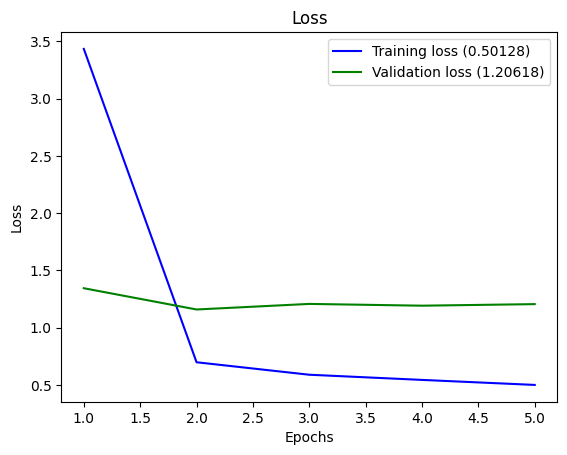

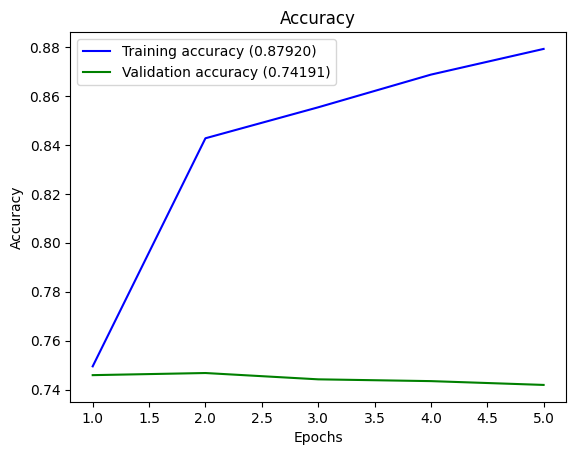

In [35]:

plot_history(history, "base128_e15")


After we trained the model, we predict the labels of our whole data set

In [27]:
from utils import evaluate_prediction

# Predict the data
y_train_pred = model.predict(train_padded_docs)
y_val_pred = model.predict(val_padded_docs)
y_test_pred = model.predict(test_padded_docs)

classes = list(le_dict.keys())
print("F1 macro scores")
print("   Validation set")
report_validation = evaluate_prediction(y_val, y_val_pred, classes)
print("   ", report_validation['macro avg']['f1-score'])

print("   Test set")
report_test = evaluate_prediction(y_test, y_test_pred, classes)
print("   ", report_test['macro avg']['f1-score'])

print("   Train set")
report_train = evaluate_prediction(y_train, y_train_pred, classes)
print("   ", report_train['macro avg']['f1-score'])

2/2 [==============================] - 1s 420ms/step
F1 macro scores
   Validation set
    0.03659892210419187
   Test set
    0.03772502790959564
   Train set
    0.07718012057260645


## GRU model
Train routine using a bidirectional GRU layer with 128 units  
Evaluate the models training progress using the validation set

In [37]:
from utils import *
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)

print("Create model...")
model = create_model(train_vocab_size, maxlen, train_embedding_matrix, model_type="gru", plot_model=True)

model.summary()

n_epochs = 15
print(f"Fit model to train data in {n_epochs} epochs... ")
history = model.fit(train_padded_docs, y_train, validation_data=(val_padded_docs, y_val), epochs=n_epochs, verbose=1, batch_size=8, callbacks=[es])

Create model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1892, 100)         683200    
                                                                 
 bidirectional_6 (Bidirectio  (None, 1892, 256)        176640    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1892, 46)          11822     
                                                                 
Total params: 871,662
Trainable params: 188,462
Non-trainable params: 683,200
_________________________________________________________________
Fit model to train data in 15 epochs... 
Epoch 1/15
13/13 [==============================] - 17s 979ms/step - loss: 3.5325 - accuracy: 0.7576 - val_loss: 3.0467 - val_accuracy: 0.7459
Epoch 2/15
13/13 [======================

plot the resulting accuracy and loss curve and save them

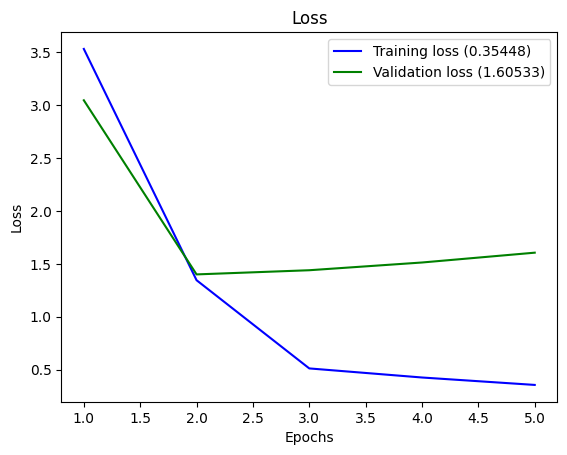

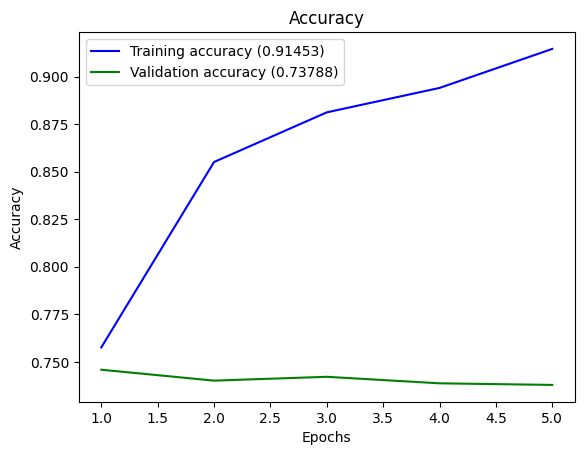

In [38]:
plot_history(history, "gru128_e15")

In [39]:
from utils import evaluate_prediction

# Predict the data
y_train_pred = model.predict(train_padded_docs)
y_val_pred = model.predict(val_padded_docs)
y_test_pred = model.predict(test_padded_docs)

classes = list(le_dict.keys())

classes = list(le_dict.keys())
print("F1 macro scores")
print("   Validation set")
report_validation = evaluate_prediction(y_val, y_val_pred, classes)
print("   ", report_validation['macro avg']['f1-score'])

print("   Test set")
report_test = evaluate_prediction(y_test, y_test_pred, classes)
print("   ", report_test['macro avg']['f1-score'])

print("   Train set")
report_train = evaluate_prediction(y_train, y_train_pred, classes)
print("   ", report_train['macro avg']['f1-score'])

2/2 [==============================] - 1s 423ms/step
Validation set
0.04203284224637656
Test set
0.043932424624347655
Train set
0.14483075436898393


## Test with an additional LSTM layer
On top of the base model, we apply an additional lstm layer

In [42]:
from utils import *
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)

print("Create model...")
model = create_model(train_vocab_size, maxlen, train_embedding_matrix, model_type="lstm", plot_model=True)

model.summary()

n_epochs = 15
print(f"Fit model to train data in {n_epochs} epochs... ")
history = model.fit(train_padded_docs, y_train, validation_data=(val_padded_docs, y_val), epochs=n_epochs, verbose=1, batch_size=8, callbacks=[es])

Create model...
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 1892, 100)         683200    
                                                                 
 bidirectional_8 (Bidirectio  (None, 1892, 256)        234496    
 nal)                                                            
                                                                 
 lstm_8 (LSTM)               (None, 1892, 128)         197120    
                                                                 
 dense_8 (Dense)             (None, 1892, 46)          5934      
                                                                 
Total params: 1,120,750
Trainable params: 437,550
Non-trainable params: 683,200
_________________________________________________________________
Fit model to train data in 15 epochs... 
Epoch 1/15
13/13 [==============================]

plot the resulting accuracy and loss curve and save them

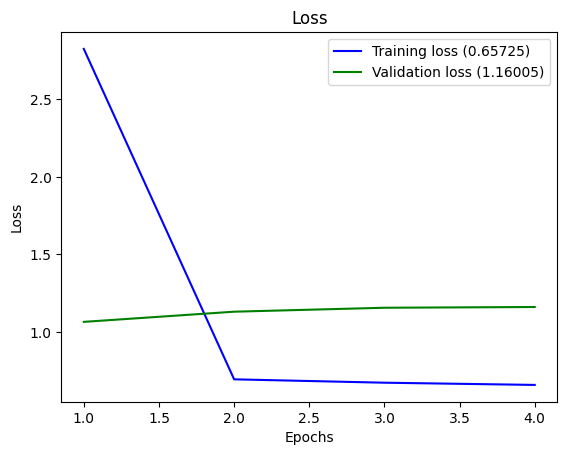

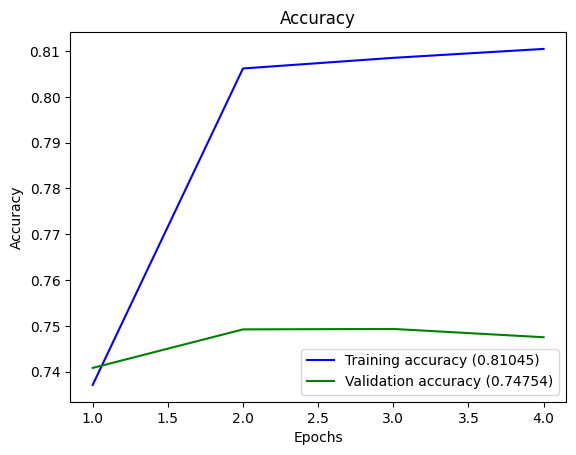

In [43]:
plot_history(history, "lstm128_e15")

In [44]:
from utils import evaluate_prediction

# Predict the data
y_train_pred = model.predict(train_padded_docs)
y_val_pred = model.predict(val_padded_docs)
y_test_pred = model.predict(test_padded_docs)

classes = list(le_dict.keys())

classes = list(le_dict.keys())
print("F1 macro scores")
print("   Validation set")
report_validation = evaluate_prediction(y_val, y_val_pred, classes)
print("   ", report_validation['macro avg']['f1-score'])

print("   Test set")
report_test = evaluate_prediction(y_test, y_test_pred, classes)
print("   ", report_test['macro avg']['f1-score'])

print("   Train set")
report_train = evaluate_prediction(y_train, y_train_pred, classes)
print("   ", report_train['macro avg']['f1-score'])

2/2 [==============================] - 2s 773ms/step
F1 macro scores
   Validation set
    0.02879457224908176
   Test set
    0.02946957729559351
   Train set
    0.033318702755877824


## Dense model
The final model with an additional dense layer

Create model...
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 1892, 100)         683200    
                                                                 
 bidirectional_12 (Bidirecti  (None, 1892, 256)        234496    
 onal)                                                           
                                                                 
 dense_13 (Dense)            (None, 1892, 128)         32896     
                                                                 
 dense_14 (Dense)            (None, 1892, 46)          5934      
                                                                 
Total params: 956,526
Trainable params: 273,326
Non-trainable params: 683,200
_________________________________________________________________
Fit model to train data in 15 epochs... 
Epoch 1/15
13/13 [==============================] 

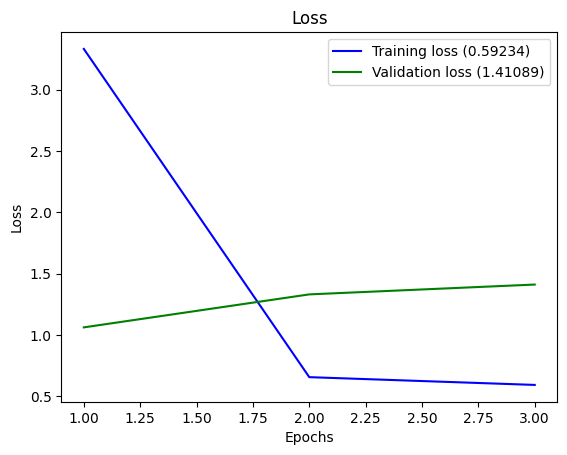

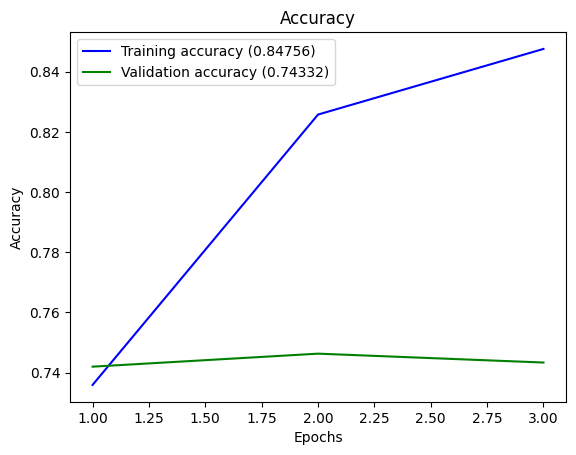

In [89]:
from utils import *
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)

print("Create model...")
model = create_model(train_vocab_size, maxlen, train_embedding_matrix, model_type="dense", plot_model=True)

model.summary()

n_epochs = 15
print(f"Fit model to train data in {n_epochs} epochs... ")
history = model.fit(train_padded_docs, y_train, validation_data=(val_padded_docs, y_val), epochs=n_epochs, verbose=1, batch_size=8, callbacks=[es])

plot the resulting accuracy and loss curve and save them

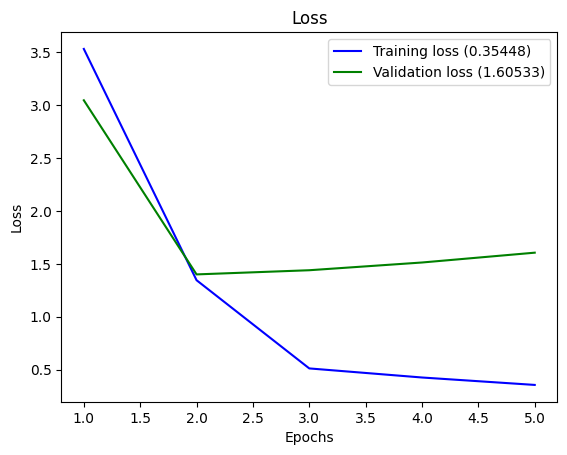

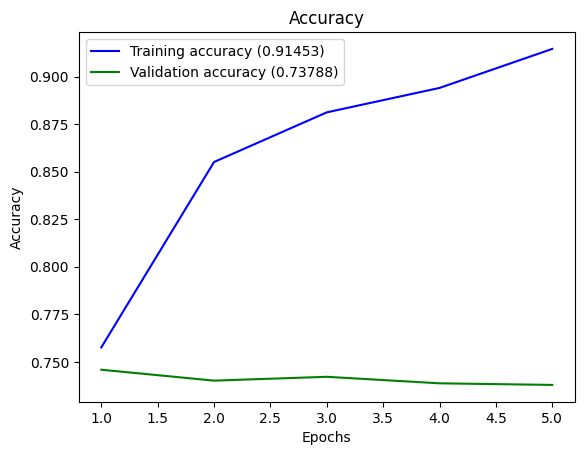

In [40]:
plot_history(history, "dense128_e15")

In [90]:
from utils import evaluate_prediction

# Predict the data
y_train_pred = model.predict(train_padded_docs)
y_val_pred = model.predict(val_padded_docs)
y_test_pred = model.predict(test_padded_docs)

classes = list(le_dict.keys())

classes = list(le_dict.keys())
print("F1 macro scores")
print("   Validation set")
report_validation = evaluate_prediction(y_val, y_val_pred, classes)
print("   ", report_validation['macro avg']['f1-score'])

print("   Test set")
report_test = evaluate_prediction(y_test, y_test_pred, classes)
print("   ", report_test['macro avg']['f1-score'])

print("   Train set")
report_train = evaluate_prediction(y_train, y_train_pred, classes)
print("   ", report_train['macro avg']['f1-score'])

2/2 [==============================] - 1s 365ms/step
Validation set
0.032172705317144897
Test set
0.03345055569801773
Train set
0.04947064248471035


In [29]:
# import numpy as np
# # predict model test
# predictions = model.predict(test_padded_docs, verbose=1)
# # map predicted labels to words
# predicted_labels = []
# for i in predictions:
#     for word, index in test_tokenizer.word_index.items():
#         if index == np.argmax(i):
#             predicted_labels.append(word)
#             break
# # map actual labels to words
# actual_labels = []
# for i in test_frame['pos'].values:
#     for word, index in test_tokenizer.word_index.items():
#         if index == i:
#             actual_labels.append(word)
#             break
# # create confusion matrix
# confusion_matrix = pd.crosstab(pd.Series(actual_labels), pd.Series(predicted_labels), rownames=['Actual'], colnames=['Predicted'])

44

In [34]:
# import numpy as np
# np.argmax(val_labels[0])
# np.argmax(predictions[0])

35

In [ ]:
model = Sequential()
# Adding the input layer and the first hidden layer
model.add(Dense(16, activation = 'relu', input_dim = 243))
# Adding the output layer
model.add(Dense(units = 1))
model.compile(optimizer = 'adam',loss = 'mean_squared_error')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40) # Model stop training after 40 epoch where validation loss didnt decrease
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True) #You save model weight at the epoch where validation loss is minimal
train = model.fit((train_X, train_label, batch_size=batch_size),epochs=1000,verbose=1,validation_data=(valid_X, valid_label),callbacks=[es,mc])#you can run for 1000 epoch btw model will stop after 40 epoch without better validation loss